In [1]:
import geopandas as gpd
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')

In [2]:
import geopandas as gpd
from scipy.spatial import Voronoi
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mpl_polygon

gdf['centroid'] = gdf.geometry.centroid
centroids = np.array([(geom.x, geom.y) for geom in gdf['centroid']])
vor = Voronoi(centroids)


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_56147/2393428381.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


In [3]:
import numpy as np
from shapely.geometry import Polygon, Point

# Step 1: Ensure centroids are Shapely Points
centroids = gdf['centroid'].apply(lambda x: Point(x.x, x.y)).tolist()

# Step 3: Convert Voronoi regions to Shapely polygons
def voronoi_to_polygons(vor, centroids):
    polygons = []
    for region_idx, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if not -1 in vertices and len(vertices) > 0:
            polygon = Polygon([vor.vertices[i] for i in vertices])
            # Ensure the polygon contains the corresponding centroid
            if polygon.contains(centroids[region_idx]):
                polygons.append(polygon)
    return polygons

# Create polygons from the Voronoi tessellation
vor_polygons = voronoi_to_polygons(vor, centroids)

# Step 4: Convert Voronoi polygons to a GeoDataFrame
vor_gdf = gpd.GeoDataFrame(geometry=vor_polygons)


In [17]:
vor_gdf.to_file('../data/xenium/voronoi.geojson', driver='GeoJSON')

In [18]:
vor_gdf.geometry

0         POLYGON ((2211.483 192.669, 2226.350 197.450, ...
1         POLYGON ((3134.631 2905.938, 3113.748 2919.271...
2         POLYGON ((3009.974 3227.427, 2825.385 3275.559...
3         POLYGON ((3069.171 3396.285, 2868.941 3644.323...
4         POLYGON ((3013.245 3251.478, 2980.023 3381.020...
                                ...                        
216318    POLYGON ((27881.089 21559.504, 27909.219 21602...
216319    POLYGON ((28922.308 21240.856, 28921.149 21243...
216320    POLYGON ((27628.111 21075.787, 27651.261 20983...
216321    POLYGON ((28855.350 20799.554, 28844.745 20824...
216322    POLYGON ((28666.644 22010.556, 28757.955 21970...
Name: geometry, Length: 216323, dtype: geometry

In [5]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

# Print the image shape
print("Image shape:", img.shape)

/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_56147/218545800.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')


Image shape: (24241, 30786, 3)


Cropped image shape: (1000, 1000, 3)


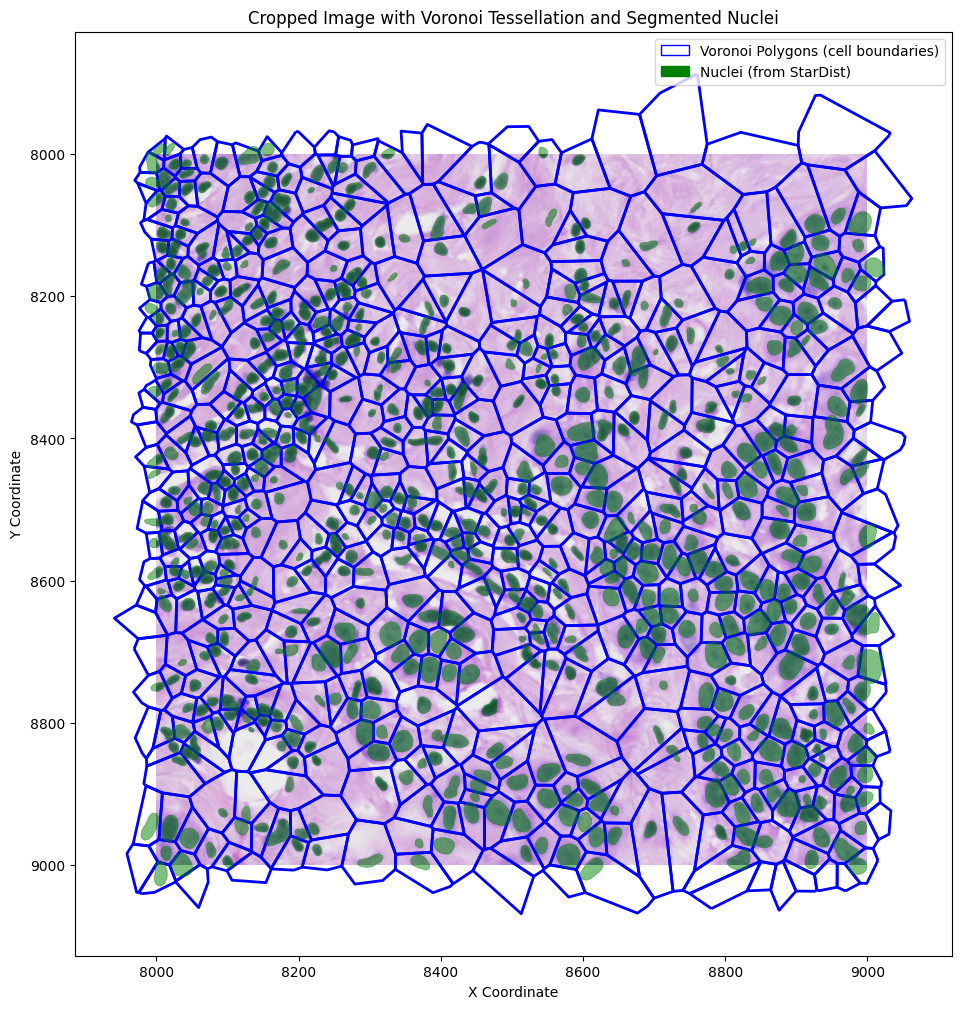

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (8000, 8000, 9000, 9000)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf[vor_gdf.intersects(bbox_polygon)]
gdf_filtered = gdf[gdf.intersects(bbox_polygon)]

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot the nuclei from the original GeoDataFrame, also filtered by the bounding box
gdf_filtered.plot(ax=ax, edgecolor='green', facecolor='green', linewidth=0.5, alpha=0.5)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='blue', facecolor='none', label='Voronoi Polygons (cell boundaries)'),
    Patch(edgecolor='green', facecolor='green', label='Nuclei (from StarDist)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation and Segmented Nuclei')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [15]:
vor_gdf.geometry

0         POLYGON ((2211.483 192.669, 2226.350 197.450, ...
1         POLYGON ((3134.631 2905.938, 3113.748 2919.271...
2         POLYGON ((3009.974 3227.427, 2825.385 3275.559...
3         POLYGON ((3069.171 3396.285, 2868.941 3644.323...
4         POLYGON ((3013.245 3251.478, 2980.023 3381.020...
                                ...                        
216318    POLYGON ((27881.089 21559.504, 27909.219 21602...
216319    POLYGON ((28922.308 21240.856, 28921.149 21243...
216320    POLYGON ((27628.111 21075.787, 27651.261 20983...
216321    POLYGON ((28855.350 20799.554, 28844.745 20824...
216322    POLYGON ((28666.644 22010.556, 28757.955 21970...
Name: geometry, Length: 216323, dtype: geometry